In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
FPATH = "../../data/sampling_results/Benchmark-3/"

function hist_2d(name, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

function hist_1d(name, dim_1; nbins=40)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    hist_tmp = fit(Histogram, smpl_tmp[dim_1,:], FrequencyWeights(smpl_w), nbins=nbins)
    hist_tmp = normalize(hist_tmp, mode=:pdf)
    return hist_tmp
end

function marg_mean(name, dim_1, dim_2)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = unshaped(mode(smpl_tmp))
    return smpl_tmp[dim_1], smpl_tmp[dim_2]
end

function marg_std(name, dim_1, dim_2)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = unshaped(std(smpl_tmp))
    return smpl_tmp[dim_1], smpl_tmp[dim_2]
end

marg_std (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.008
β3 = 0.006 
    

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.07, 0.25), truncated(Normal(0.2, 0.04), 0.07, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
        mixt_pow =  0.52 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );   

labels = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [4]:
filenames = readdir("../../data/sampling_results/Benchmark-3/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2");
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [5]:
filenames = readdir("../../data/sampling_results/Benchmark-3/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2");
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [6]:
fnames = [lc_fnames; hc_fnames]
charges = [lc_charge; hc_charge]
runind = [lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [7]:
fnames

18-element Array{String,1}:
 "lc-1.hdf5"
 "lc-137.hdf5"
 "lc-151.hdf5"
 "lc-169.hdf5"
 "lc-2.hdf5"
 "lc-225.hdf5"
 "lc-262.hdf5"
 "lc-299.hdf5"
 "lc-3.hdf5"
 "lc-343.hdf5"
 "hc-1.hdf5"
 "hc-113.hdf5"
 "hc-188.hdf5"
 "hc-2.hdf5"
 "hc-26.hdf5"
 "hc-281.hdf5"
 "hc-3.hdf5"
 "hc-322.hdf5"

In [8]:
msklc = 1:length(lc_fnames)
mskhc = length(lc_fnames)+1:length(lc_fnames)+length(hc_fnames);

In [9]:
charges_n[sortperm(charges_n)] .= 1:length(charges_n)
charges_n = charges_n ./ maximum(charges_n);

## Plot 1: 

In [10]:
hists = [hist_2d(i, 1,2) for i in fnames]
mean_vals = [marg_mean(i, 1,2) for i in fnames]
std_vals = [marg_std(i, 1,2) for i in fnames]
hist1d_1 = [hist_1d(i, 1) for i in fnames]
hist1d_2 = [hist_1d(i, 2) for i in fnames];

In [11]:
argmax([i[1] for i in std_vals])

10

In [12]:
xmin, xmax = 0.07, 0.24
xrange=range(xmin, stop = xmax,length=100)
yrange=range(xmin, stop = xmax,length=100)
xvals = [pdf(truncated(Normal(0.2, 0.04), 0.07, 0.25), x) for x in xrange]
yvals = [pdf(truncated(Normal(0.2, 0.04), 0.07, 0.25), y)  for y in yrange]
z = xvals*yvals';

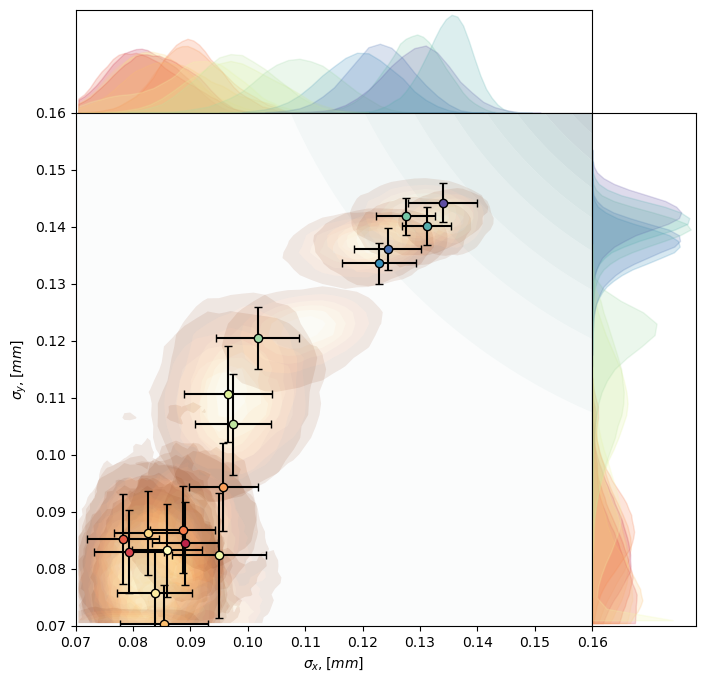

PyObject Text(29.299999999999997, 0.5, '$\\sigma_y, [mm]$')

In [13]:
fig, ax= plt.subplots(2,2, figsize=(8,8), gridspec_kw=Dict("width_ratios"=>[5,1], "height_ratios"=>[1,5]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

ax[2,1].contourf(xrange, yrange, z, levels=range(0.1*minimum(z), maximum(z), length=25)[1:end], cmap="bone_r", alpha=0.5, antialiased=true) 

for i in eachindex(hists)
    ax[2,1].contourf(midpoints(hists[i].edges[1]), midpoints(hists[i].edges[2]), hists[i].weights', 
        levels=range(0.01*minimum(hists[i].weights), maximum(hists[i].weights), length=8)[2:end],  
        alpha=0.1, linewidths=1.5, antialiased=true, cmap="YlOrBr_r"
    )
end

for i in eachindex(hists)    
    ax[2,1].errorbar(mean_vals[i][1], mean_vals[i][2], xerr=std_vals[i][1], yerr=std_vals[i][2], 
        color="k", 
        fmt="o", 
        mfc=plt.cm.Spectral(charges_n[i]), #red
        markeredgecolor = "k",  
        capsize=3, ecolor="k")
    
    ax[1,1].fill_between(midpoints(hist1d_1[i].edges[1]), hist1d_1[i].weights, color=mfc=plt.cm.Spectral(charges_n[i]), alpha=0.2)
    ax[2,2].fill_betweenx(midpoints(hist1d_2[i].edges[1]), hist1d_2[i].weights, color=mfc=plt.cm.Spectral(charges_n[i]), alpha=0.2)
end

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

# ax[1,1].plot(xrange, xvals, color="cadetblue")
# ax[2,2].plot(yvals, yrange,  color="cadetblue")

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[2,2].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.07, 0.16)
ax[1,1].set_xlim(0.07, 0.16)
ax[2,1].set_ylim(0.07, 0.16)
ax[2,2].set_ylim(0.07, 0.16)

ax[2,1].set_xlabel(L"\sigma_x, [mm]")
ax[2,1].set_ylabel(L"\sigma_y, [mm]")

In [14]:
hists = [hist_2d(i, 1,2, axmin=[0.06,0.06], axmax=[0.18,0.18], nbins=50,) for i in fnames];

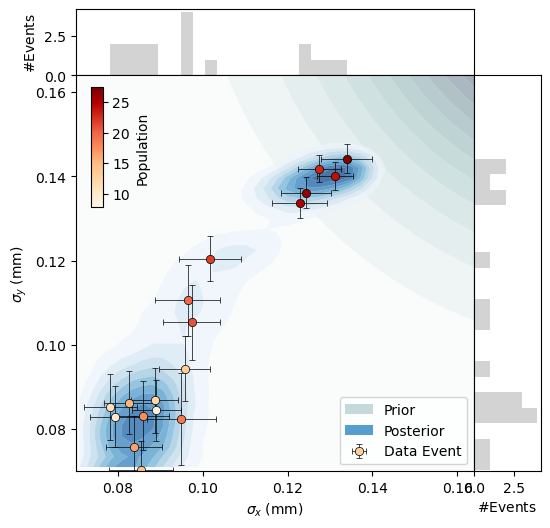

PyObject Text(38.175, 0.5, '$\\mathrm{\\# Events}$')

In [15]:
fig, ax= plt.subplots(2,2, figsize=(6,6), gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

ax[2,1].contourf(xrange, yrange, z, levels=range(0.1*minimum(z), maximum(z), length=25)[1:end], cmap="bone_r", alpha=0.7, antialiased=true) 

sum_weights = zeros(size(hists[1].weights'))

for i in eachindex(hists)
    sum_weights = sum_weights .+ hists[i].weights'
end

label = "Data Event"
for i in eachindex(hists)    
    ax[2,1].errorbar(mean_vals[i][1], mean_vals[i][2], xerr=std_vals[i][1], yerr=std_vals[i][2], 
        color="k", 
        fmt="o", 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5,
        capsize=2, ecolor="k", elinewidth=0.5, label=label)
    label = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.15,0.55,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

proxy = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.bone_r(0.17), label="Prior")
proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[2,1].add_patch(proxy)
ax[2,1].add_patch(proxy2)
ax[2,1].legend(loc="lower right")

ax[1,1].hist([i[1] for i in mean_vals], bins=20, color="lightgray")
ax[2,2].hist([i[2] for i in mean_vals], bins=20, orientation="horizontal", color="lightgray")

cnt = ax[2,1].contourf(midpoints(hists[1].edges[1]), midpoints(hists[1].edges[2]), broadcast(x-> x>1 ? x : NaN, sum_weights), 
    levels=range(minimum(sum_weights), maximum(sum_weights), length=11)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.7, antialiased=true) 

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
# ax[1,1].set_yticks([])
# ax[2,2].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.07, 0.164)
ax[1,1].set_xlim(0.07, 0.164)
ax[2,1].set_ylim(0.07, 0.164)
ax[2,2].set_ylim(0.07, 0.164)

ax[2,1].set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

## Plot 2: 

In [16]:
hists = [hist_2d(i, 3,4) for i in fnames]
mean_vals = [marg_mean(i, 3,4) for i in fnames]
mean_vals_2 = [marg_mean(i, 5,6) for i in fnames]
std_vals = [marg_std(i, 3,4) for i in fnames]
std_vals_2 = [marg_std(i, 5,6) for i in fnames];

In [17]:
xmin, xmax = 1, 7
xrange=range(xmin, stop = xmax,length=300)
yrange=range(xmin, stop = xmax,length=300)
xvals = [pdf(truncated(Normal(4, 2), 1, 7), x) for x in xrange]
yvals = [pdf(truncated(Normal(4, 2), 1, 7), y)  for y in yrange]
z = xvals*yvals';

In [18]:
hists = [hist_2d(i, 3,4, axmin=[4,4], axmax=[7,7]) for i in fnames];
hists_2 = [hist_2d(i, 5,6, axmin=[1.0,1.0], axmax=[3.5,3.5]) for i in fnames];

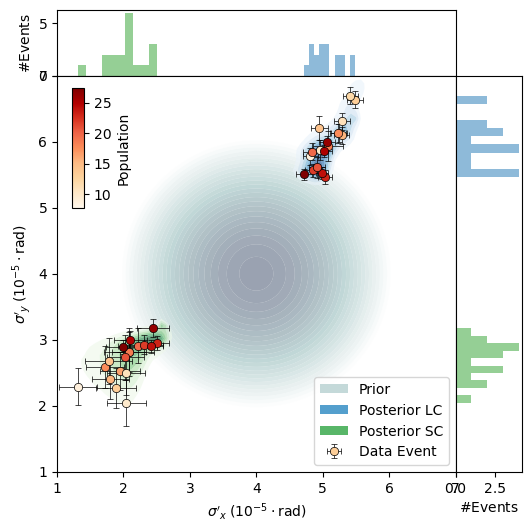

PyObject Text(32.90000000000001, 0.5, '$\\mathrm{\\# Events}$')

In [19]:
fig, ax= plt.subplots(2,2, figsize=(6,6), gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

ax[2,1].contourf(xrange, yrange, z, levels=range(0.6*maximum(z), 1.4*maximum(z), length=50)[1:end], cmap="bone_r", alpha=0.7, antialiased=true) 

sum_weights = zeros(size(hists[1].weights'))
sum_weights_2 = zeros(size(hists_2[1].weights'))

for i in eachindex(hists)
    sum_weights = sum_weights .+ hists[i].weights'
    sum_weights_2 = sum_weights_2 .+ hists_2[i].weights'
end

label = "Data Event"
for i in eachindex(hists)    
    ax[2,1].errorbar(mean_vals[i][1], mean_vals[i][2], xerr=std_vals[i][1], yerr=std_vals[i][2], 
        color="k", 
        fmt="o", 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5,
        capsize=2, ecolor="k", elinewidth=0.5, label=label)
    label = ""
    ax[2,1].errorbar(mean_vals_2[i][1], mean_vals_2[i][2], xerr=std_vals_2[i][1], yerr=std_vals_2[i][2], 
        color="k", 
        fmt="o", 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5,
        capsize=2, ecolor="k", elinewidth=0.5, label=label)
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.15,0.55,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

proxy = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.bone_r(0.17), label="Prior")
proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior LC")
proxy3 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Greens(0.57), label="Posterior SC")
ax[2,1].add_patch(proxy)
ax[2,1].add_patch(proxy2)
ax[2,1].add_patch(proxy3)
ax[2,1].legend(loc="lower right")

ax[1,1].hist([i[1] for i in mean_vals], bins=10, alpha=0.5, color="C0")
ax[1,1].hist([i[1] for i in mean_vals_2], bins=10, alpha=0.5, color="C2")
ax[2,2].hist([i[2] for i in mean_vals], bins=10, alpha=0.5, orientation="horizontal", color="C0")
ax[2,2].hist([i[2] for i in mean_vals_2], bins=10, alpha=0.5, orientation="horizontal", color="C2")

cnt = ax[2,1].contourf(midpoints(hists[1].edges[1]), midpoints(hists[1].edges[2]), broadcast(x-> x>1 ? x : NaN, sum_weights), 
    levels=range(minimum(sum_weights), maximum(sum_weights), length=9)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.6, antialiased=true) 

cnt = ax[2,1].contourf(midpoints(hists_2[1].edges[1]), midpoints(hists_2[1].edges[2]), broadcast(x-> x>1 ? x : NaN, sum_weights_2), 
    levels=range(minimum(sum_weights_2), maximum(sum_weights_2), length=9)[2:end], #corner_mask= true,
    cmap="Greens", alpha=0.6, antialiased=true) 

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(1, 7 )
ax[1,1].set_xlim(1, 7)
ax[2,1].set_ylim(1, 7.)
ax[2,2].set_ylim(1, 7)

ax[2,1].set_xlabel(L"\sigma'_x \; (\mathrm{10^{-5} \cdot rad})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma'_y \; (\mathrm{10^{-5} \cdot rad})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

## Plot #3

In [20]:
hist1d_1 = [hist_1d(i, 8, nbins=50) for i in fnames]
mean_vals = [marg_mean(i, 8,8) for i in fnames];

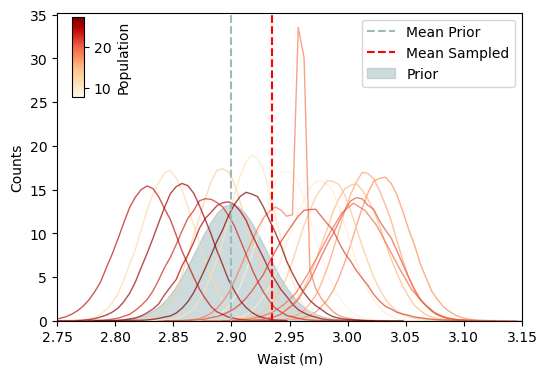

PyObject <matplotlib.legend.Legend object at 0x7fd969b4a1f0>

In [21]:
fig, ax= plt.subplots(1,1, figsize=(6,4), )

x_range = range(2.7, stop=3.3, length=100)
ax.fill_between(x_range, pdf.(Normal(2.9, 0.03), x_range), color=plt.cm.bone_r(0.3), label="Prior", alpha=0.5)

for i in eachindex(hists)  
    ax.plot(midpoints(hist1d_1[i].edges[1]), hist1d_1[i].weights, color=plt.cm.OrRd(charges_n[i]), alpha=0.7, lw=1)
end

cb = ax.scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.15,0.67,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

ax.axvline([2.9], color=plt.cm.bone_r(0.3), ls="--", label="Mean Prior")
ax.axvline(mean([i[2] for i in mean_vals]), color="red", ls="--", label="Mean Sampled")

ax.set_ylim(bottom=0.0,)
ax.set_xlim(2.75, 3.15)

ax.set_xlabel(L"\mathrm{Waist \; (m)}")
ax.set_ylabel("Counts")
ax.legend()

## Plot #4

In [22]:
hists1 = [hist_2d(i, 20,23, axmin=[0,0], axmax=[5,5]) for i in fnames]
hists2 = [hist_2d(i, 21,24, axmin=[0,0], axmax=[5,5]) for i in fnames]
hists3 = [hist_2d(i, 22,25, axmin=[0,0], axmax=[3,3]) for i in fnames]
hists4 = [hist_2d(i, 26,27, axmin=[4,2], axmax=[8,8]) for i in fnames]


mean_vals1 = [marg_mean(i, 20,23) for i in fnames]
mean_vals2 = [marg_mean(i, 21,24) for i in fnames]
mean_vals3 = [marg_mean(i, 22,25) for i in fnames]
mean_vals4 = [marg_mean(i, 26,27) for i in fnames]

std_vals1 = [marg_std(i, 20,23) for i in fnames]
std_vals2 = [marg_std(i, 21,24) for i in fnames]
std_vals3 = [marg_std(i, 22,25) for i in fnames]
std_vals4 = [marg_std(i, 26,27) for i in fnames];

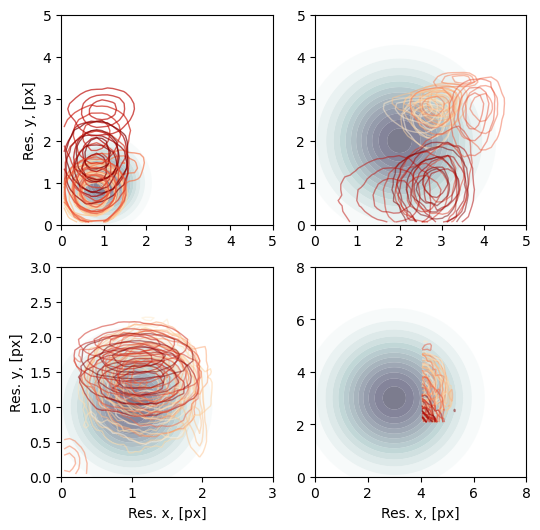

PyObject Text(24.000000000000007, 0.5, 'Res. y, [px]')

In [23]:
xrange=range(0, stop = 8,length=200)
yrange=range(0, stop = 8,length=200)

fig, ax= plt.subplots(2,2, figsize=(6,6),)

z1 = pdf.(truncated(Normal(1, 0.5), 0, Inf), xrange); z1 = z1 * z1'
ax[1,1].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.4*maximum(z1), length=20)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(2, 1), 0, Inf), xrange); z1 = z1 * z1'
ax[1,2].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.4*maximum(z1), length=20)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(1, 0.5), 0, Inf), xrange); z1 = z1 * z1'
ax[2,1].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.4*maximum(z1), length=20)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(3, 1.5), 0, Inf), xrange); z1 = z1 * z1'
ax[2,2].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.4*maximum(z1), length=20)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 


for i in eachindex(hists)
    ax[1,1].contour(midpoints(hists1[i].edges[1]), midpoints(hists1[i].edges[2]), hists1[i].weights', 
        levels=range(minimum(hists1[i].weights), maximum(hists1[i].weights), length=5)[2:end],  
        alpha=0.7, linewidths=1, antialiased=true, colors=plt.cm.OrRd(charges_n[i]),
    )
    
    ax[1,2].contour(midpoints(hists2[i].edges[1]), midpoints(hists2[i].edges[2]), hists2[i].weights', 
        levels=range(minimum(hists2[i].weights), maximum(hists2[i].weights), length=5)[2:end],  
        alpha=0.5, linewidths=1, antialiased=true, colors=plt.cm.OrRd(charges_n[i]),
    )
    
    ax[2,1].contour(midpoints(hists3[i].edges[1]), midpoints(hists3[i].edges[2]), hists3[i].weights', 
        levels=range(minimum(hists3[i].weights), maximum(hists3[i].weights), length=5)[2:end],  
        alpha=0.5, linewidths=1, antialiased=true, colors=plt.cm.OrRd(charges_n[i]),
    )
    
    ax[2,2].contour(midpoints(hists4[i].edges[1]), midpoints(hists4[i].edges[2]), hists4[i].weights', 
        levels=range(minimum(hists4[i].weights), maximum(hists4[i].weights), length=5)[2:end],  
        alpha=0.5, linewidths=1, antialiased=true, colors=plt.cm.OrRd(charges_n[i]),
    )
end

ax[1,1].set_ylim(bottom=0.0, top=5)
ax[1,1].set_xlim(left=0.0, right=5)

ax[1,2].set_ylim(bottom=0.0, top=5)
ax[1,2].set_xlim(left=0.0, right=5)

ax[2,1].set_ylim(bottom=0.0, top=3)
ax[2,1].set_xlim(left=0.0, right=3)

ax[2,2].set_ylim(bottom=0.0, top=8)
ax[2,2].set_xlim(left=0.0, right=8)


ax[2,2].set_xlabel("Res. x, [px]")
ax[2,1].set_xlabel("Res. x, [px]")


ax[1,1].set_ylabel("Res. y, [px]")
ax[2,1].set_ylabel("Res. y, [px]")

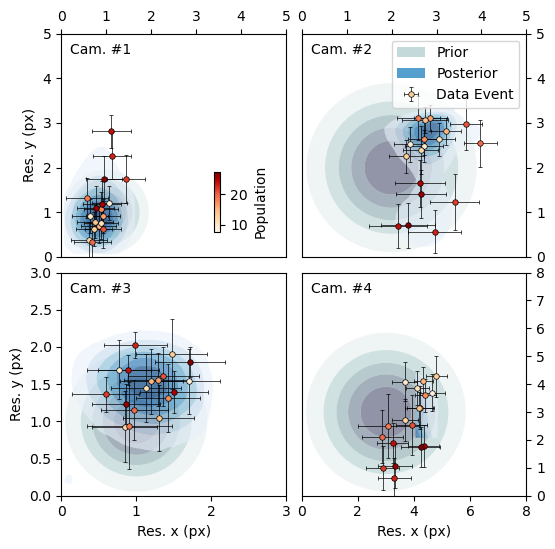

PyObject Text(24.000000000000007, 0.5, 'Res. y (px)')

In [24]:
xrange=range(0, stop = 8,length=200)
yrange=range(0, stop = 8,length=200)

fig, ax= plt.subplots(2,2, figsize=(6,6),)
fig.subplots_adjust(hspace=0.07, wspace=0.07)

z1 = pdf.(truncated(Normal(1, 0.5), 0, Inf), xrange); z1 = z1 * z1'
ax[1,1].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.5*maximum(z1), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(2, 1), 0, Inf), xrange); z1 = z1 * z1'
ax[1,2].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.5*maximum(z1), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(1, 0.5), 0, Inf), xrange); z1 = z1 * z1'
ax[2,1].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.5*maximum(z1), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

z1 = pdf.(truncated(Normal(3, 1.5), 0, Inf), xrange); z1 = z1 * z1'
ax[2,2].contourf(xrange, yrange, z1, levels=range(minimum(z1), stop=1.5*maximum(z1), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

sum_weights1 = zeros(size(hists1[1].weights'))
sum_weights2 = zeros(size(hists2[1].weights'))
sum_weights3 = zeros(size(hists3[1].weights'))
sum_weights4 = zeros(size(hists4[1].weights'))

for i in eachindex(hists)
    sum_weights1 = sum_weights1 .+ hists1[i].weights'
    sum_weights2 = sum_weights2 .+ hists2[i].weights'
    sum_weights3 = sum_weights3 .+ hists3[i].weights'
    sum_weights4 = sum_weights4 .+ hists4[i].weights'
end


cnt = ax[1,1].contourf(midpoints(hists1[1].edges[1]), midpoints(hists1[1].edges[2]), broadcast(x-> x>0.5 ? x : NaN, sum_weights1), 
    levels=range(minimum(sum_weights1), maximum(sum_weights1), length=8)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.6, antialiased=true) 

cnt = ax[1,2].contourf(midpoints(hists2[1].edges[1]), midpoints(hists2[1].edges[2]), broadcast(x-> x>0.5 ? x : NaN, sum_weights2), 
    levels=range(minimum(sum_weights2), maximum(sum_weights2), length=8)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.6, antialiased=true) 

cnt = ax[2,1].contourf(midpoints(hists3[1].edges[1]), midpoints(hists3[1].edges[2]), broadcast(x-> x>0.5 ? x : NaN, sum_weights3), 
    levels=range(minimum(sum_weights3), maximum(sum_weights3), length=8)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.6, antialiased=true) 

cnt = ax[2,2].contourf(midpoints(hists4[1].edges[1]), midpoints(hists4[1].edges[2]), broadcast(x-> x>0.5 ? x : NaN, sum_weights4), 
    levels=range(minimum(sum_weights4), maximum(sum_weights4), length=8)[2:end], #corner_mask= true,
    cmap="Blues", alpha=0.6, antialiased=true) 

label = "Data Event"
for i in eachindex(hists)    
    ax[1,1].errorbar(mean_vals1[i][1], mean_vals1[i][2], xerr=std_vals1[i][1], yerr=std_vals1[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[1,2].errorbar(mean_vals2[i][1], mean_vals2[i][2], xerr=std_vals2[i][1], yerr=std_vals2[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,1].errorbar(mean_vals3[i][1], mean_vals3[i][2], xerr=std_vals3[i][1], yerr=std_vals3[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,2].errorbar(mean_vals4[i][1], mean_vals4[i][2], xerr=std_vals4[i][1], yerr=std_vals4[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    label = ""
end

cb = ax[1,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.38,0.55,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

proxy = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.bone_r(0.17), label="Prior")
proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[1,2].add_patch(proxy)
ax[1,2].add_patch(proxy2)
ax[1,2].legend(loc="upper right")

ax[1,1].text(0.04,0.91,"Cam. #1", transform=ax[1,1].transAxes)
ax[1,2].text(0.04,0.91,"Cam. #2", transform=ax[1,2].transAxes)
ax[2,1].text(0.04,0.91,"Cam. #3", transform=ax[2,1].transAxes)
ax[2,2].text(0.04,0.91,"Cam. #4", transform=ax[2,2].transAxes)

ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticks_position("top")
ax[1,1].set_ylim(bottom=0.0, top=5)
ax[1,1].set_xlim(left=0.0, right=5)

ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticks_position("top")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")
ax[1,2].set_ylim(bottom=0.0, top=5)
ax[1,2].set_xlim(left=0.0, right=5)

ax[2,1].set_ylim(bottom=0.0, top=3)
ax[2,1].set_xlim(left=0.0, right=3)

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")
ax[2,2].set_ylim(bottom=0.0, top=8)
ax[2,2].set_xlim(left=0.0, right=8)


ax[2,2].set_xlabel("Res. x (px)")
ax[2,1].set_xlabel("Res. x (px)")


ax[1,1].set_ylabel("Res. y (px)")
ax[2,1].set_ylabel("Res. y (px)")

## Plot #5

In [25]:
hists1 = [hist_2d(i, 28,31, axmin=[22, 22], axmax=[36,36], nbins=100) for i in fnames]
hists2 = [hist_2d(i, 29,32, axmin=[18, 18], axmax=[30,30], nbins=100) for i in fnames]
hists3 = [hist_2d(i, 30,33, axmin=[106, 106], axmax=[135,135], nbins=100) for i in fnames]
hists4 = [hist_2d(i, 34,35, axmin=[106, 106], axmax=[130,130], nbins=100) for i in fnames]

mean_vals1 = [marg_mean(i, 28,31) for i in fnames]
mean_vals2 = [marg_mean(i, 29,32) for i in fnames]
mean_vals3 = [marg_mean(i, 30,33) for i in fnames]
mean_vals4 = [marg_mean(i, 34,35) for i in fnames]

std_vals1 = [marg_std(i, 28,31) for i in fnames]
std_vals2 = [marg_std(i, 29,32) for i in fnames]
std_vals3 = [marg_std(i, 30,33) for i in fnames]
std_vals4 = [marg_std(i, 34,35) for i in fnames];

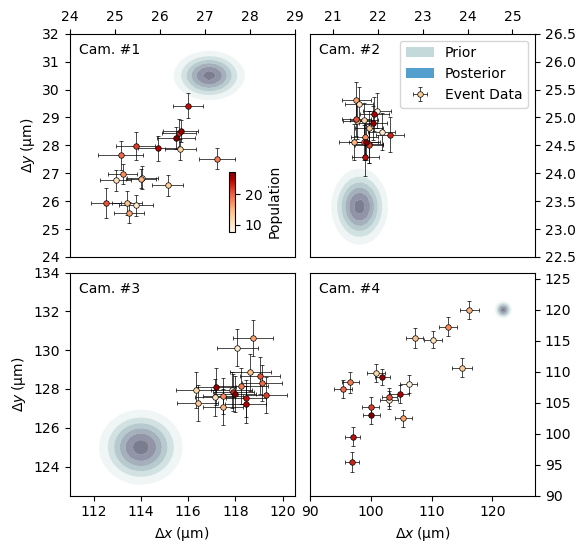

PyObject Text(28.000000000000007, 0.5, '$\\Delta y \\; \\mathrm{(\\mu m)}$')

In [26]:
fig, ax= plt.subplots(2,2, figsize=(6,6),)
fig.subplots_adjust(hspace=0.07, wspace=0.07)

xrange=range(22, stop = 36,length=100)
yrange=range(22, stop = 36,length=100)
z = [pdf(truncated(Normal(27.1, 27.1*β1), 0., Inf), x)*pdf(truncated(Normal(30.5, 30.5*β1), 0., Inf), y) for x in xrange, y in yrange]'
ax[1,1].contourf(xrange, yrange, z, levels=range(minimum(z), stop=1.4*maximum(z), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

xrange=range(18, stop = 30,length=100)
yrange=range(18, stop = 30,length=100)
z = [pdf(truncated(Normal(21.6, 21.6*β1), 0., Inf), x)*pdf(truncated(Normal(23.4, 23.4*β1), 0., Inf), y) for x in xrange, y in yrange]'
ax[1,2].contourf(xrange, yrange, z, levels=range(minimum(z), stop=1.4*maximum(z), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

xrange=range(106, stop = 123,length=100)
yrange=range(120, stop = 135,length=100)
z = [pdf(truncated(Normal(114.0, 114.0*β2), 0., Inf), x)*pdf(truncated(Normal(125.0, 125.0*β2), 0., Inf), y) for x in xrange, y in yrange]'
ax[2,1].contourf(xrange, yrange, z, levels=range(minimum(z), stop=1.4*maximum(z), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

xrange=range(106, stop = 130,length=100)
yrange=range(110, stop = 135,length=100)
z = [pdf(truncated(Normal(121.8, 121.8*β3), 0., Inf), x)*pdf(truncated(Normal(120.0, 120.0*β3), 0., Inf), y) for x in xrange, y in yrange]'
ax[2,2].contourf(xrange, yrange, z, levels=range(minimum(z), stop=1.4*maximum(z), length=10)[2:end], cmap="bone_r", alpha=0.7, antialiased=true) 

sum_weights1 = zeros(size(hists1[1].weights'))
sum_weights2 = zeros(size(hists2[1].weights'))
sum_weights3 = zeros(size(hists3[1].weights'))
sum_weights4 = zeros(size(hists4[1].weights'))

for i in eachindex(hists)
    sum_weights1 = sum_weights1 .+ hists1[i].weights'
    sum_weights2 = sum_weights2 .+ hists2[i].weights'
    sum_weights3 = sum_weights3 .+ hists3[i].weights'
    sum_weights4 = sum_weights4 .+ hists4[i].weights'
end


# cnt = ax[1,1].contourf(midpoints(hists1[1].edges[1]), midpoints(hists1[1].edges[2]), broadcast(x-> x>0.2 ? x : NaN, sum_weights1), 
#     levels=range(minimum(sum_weights1),  stop = maximum(sum_weights1), length=8)[2:end], #corner_mask= true,
#     cmap="Blues", alpha=0.5, antialiased=true) 

# cnt = ax[1,2].contourf(midpoints(hists2[1].edges[1]), midpoints(hists2[1].edges[2]), broadcast(x-> x>0.2 ? x : NaN, sum_weights2), 
#     levels=range(minimum(sum_weights2),  stop = maximum(sum_weights2), length=8)[2:end], #corner_mask= true,
#     cmap="Blues", alpha=0.5, antialiased=true) 

# cnt = ax[2,1].contourf(midpoints(hists3[1].edges[1]), midpoints(hists3[1].edges[2]), broadcast(x-> x>0.2 ? x : NaN, sum_weights3), 
#     levels=range(minimum(sum_weights3),  stop = maximum(sum_weights3), length=8)[2:end], #corner_mask= true,
#     cmap="Blues", alpha=0.5, antialiased=true) 

# cnt = ax[2,2].contourf(midpoints(hists4[1].edges[1]), midpoints(hists4[1].edges[2]), broadcast(x-> x>0.2 ? x : NaN, sum_weights4), 
#     levels=range(minimum(sum_weights4), stop = maximum(sum_weights4), length=8)[2:end], #corner_mask= true,
#     cmap="Blues", alpha=0.5, antialiased=true) 

label = "Event Data"
for i in eachindex(hists)    
    ax[1,1].errorbar(mean_vals1[i][1], mean_vals1[i][2], xerr=std_vals1[i][1], yerr=std_vals1[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[1,2].errorbar(mean_vals2[i][1], mean_vals2[i][2], xerr=std_vals2[i][1], yerr=std_vals2[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,1].errorbar(mean_vals3[i][1], mean_vals3[i][2], xerr=std_vals3[i][1], yerr=std_vals3[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,2].errorbar(mean_vals4[i][1], mean_vals4[i][2], xerr=std_vals4[i][1], yerr=std_vals4[i][2], 
        color="k", 
        fmt="o", markersize = 4,
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    label = ""
end

cb = ax[1,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.39,0.55,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Population", cax=ax_ins_3)

proxy = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.bone_r(0.17), label="Prior")
proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[1,2].add_patch(proxy)
ax[1,2].add_patch(proxy2)
ax[1,2].legend(loc="upper right")

ax[1,1].text(0.04,0.91,"Cam. #1", transform=ax[1,1].transAxes)
ax[1,2].text(0.04,0.91,"Cam. #2", transform=ax[1,2].transAxes)
ax[2,1].text(0.04,0.91,"Cam. #3", transform=ax[2,1].transAxes)
ax[2,2].text(0.04,0.91,"Cam. #4", transform=ax[2,2].transAxes)

ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticks_position("top")
ax[1,1].set_ylim(24,32)
ax[1,1].set_xlim(24,29)

ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticks_position("top")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")
ax[1,2].set_xlim(20.5,25.5)
ax[1,2].set_ylim(22.5,26.5)

ax[2,1].set_xlim(111,120.5)
ax[2,1].set_ylim(122.5,134)

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")
ax[2,2].set_xlim(90,127)
ax[2,2].set_ylim(90,126)


ax[2,2].set_xlabel(L"\Delta x \; \mathrm{(\mu m)}")
ax[2,1].set_xlabel(L"\Delta x \; \mathrm{(\mu m)}")

ax[1,1].set_ylabel(L"\Delta y \; \mathrm{(\mu m)}")
ax[2,1].set_ylabel(L"\Delta y \; \mathrm{(\mu m)}")

## Plot #6

In [27]:
hists1 = [hist_2d(i, 9,13) for i in fnames]
hists2 = [hist_2d(i, 10,14) for i in fnames]
hists3 = [hist_2d(i, 11,15) for i in fnames]
hists4 = [hist_2d(i, 12,16) for i in fnames]

mean_vals1 = [marg_mean(i, 9,13) for i in fnames]
mean_vals2 = [marg_mean(i, 10,14) for i in fnames]
mean_vals3 = [marg_mean(i, 11,15) for i in fnames]
mean_vals4 = [marg_mean(i, 12,16) for i in fnames]

std_vals1 = [marg_std(i, 9,13) for i in fnames]
std_vals2 = [marg_std(i, 10,14) for i in fnames]
std_vals3 = [marg_std(i, 11,15) for i in fnames]
std_vals4 = [marg_std(i, 12,16) for i in fnames];

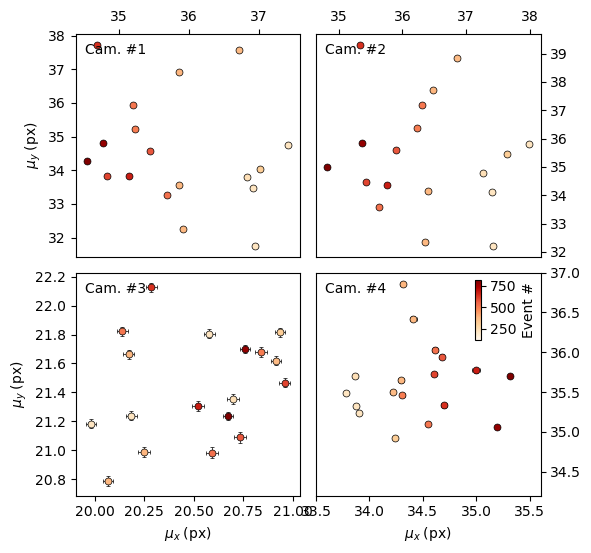

PyObject Text(29.299999999999997, 0.5, '$\\mu_y \\; \\mathrm{(px)}$')

In [28]:
fig, ax= plt.subplots(2,2, figsize=(6,6),)
fig.subplots_adjust(hspace=0.07, wspace=0.07)

label = "Mean + Std"
for i in eachindex(hists)    
    ax[1,1].errorbar(mean_vals1[i][1], mean_vals1[i][2], xerr=std_vals1[i][1], yerr=std_vals1[i][2], 
        color="k", 
        fmt="o", markersize = 5,
        mfc=plt.cm.OrRd(runind_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    label = ""
    ax[1,2].errorbar(mean_vals2[i][1], mean_vals2[i][2], xerr=std_vals2[i][1], yerr=std_vals2[i][2], 
        color="k", 
        fmt="o", markersize = 5,
        mfc=plt.cm.OrRd(runind_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,1].errorbar(mean_vals3[i][1], mean_vals3[i][2], xerr=std_vals3[i][1], yerr=std_vals3[i][2], 
        color="k", 
        fmt="o", markersize = 5,
        mfc=plt.cm.OrRd(runind_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
    ax[2,2].errorbar(mean_vals4[i][1], mean_vals4[i][2], xerr=std_vals4[i][1], yerr=std_vals4[i][2], 
        color="k", 
        fmt="o", markersize = 5,
        mfc=plt.cm.OrRd(runind_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5, label=label)
end

cb = ax[2,2].scatter(charges_n, charges_n, s=0.0, c=runind, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.79,0.37,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticks_position("top")

ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticks_position("top")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")

ax[1,1].text(0.04,0.91,"Cam. #1", transform=ax[1,1].transAxes)
ax[1,2].text(0.04,0.91,"Cam. #2", transform=ax[1,2].transAxes)
ax[2,1].text(0.04,0.91,"Cam. #3", transform=ax[2,1].transAxes)
ax[2,2].text(0.04,0.91,"Cam. #4", transform=ax[2,2].transAxes)

ax[2,2].set_xlim(33.5,35.6)
ax[2,2].set_ylim(34.2,37)

ax[2,2].set_xlabel(L"\mu_x \; \mathrm{(px)}")
ax[2,1].set_xlabel(L"\mu_x \; \mathrm{(px)}")

ax[1,1].set_ylabel(L"\mu_y \; \mathrm{(px)}")
ax[2,1].set_ylabel(L"\mu_y \; \mathrm{(px)}")

## Plot #7

In [29]:
mean_vals_t1 = [marg_mean(i, 1,2) for i in fnames]
mean_vals_t2 = [marg_mean(i, 3,4) for i in fnames]
mean_vals_t3 = [marg_mean(i, 5,6) for i in fnames]

mean_vals_1 = [i[1] for i in mean_vals_t1]
mean_vals_2 = [i[2] for i in mean_vals_t1]
mean_vals_3 = [i[1] for i in mean_vals_t2]
mean_vals_4 = [i[2] for i in mean_vals_t2]
mean_vals_5 = [i[1] for i in mean_vals_t3]
mean_vals_6 = [i[2] for i in mean_vals_t3];

In [30]:
std_vals_t1 = [marg_std(i, 1,2) for i in fnames]
std_vals_t2 = [marg_std(i, 3,4) for i in fnames]
std_vals_t3 = [marg_std(i, 5,6) for i in fnames]

std_vals_1 = [i[1] for i in std_vals_t1]
std_vals_2 = [i[2] for i in std_vals_t1]
std_vals_3 = [i[1] for i in std_vals_t2]
std_vals_4 = [i[2] for i in std_vals_t2]
std_vals_5 = [i[1] for i in std_vals_t3]
std_vals_6 = [i[2] for i in std_vals_t3];

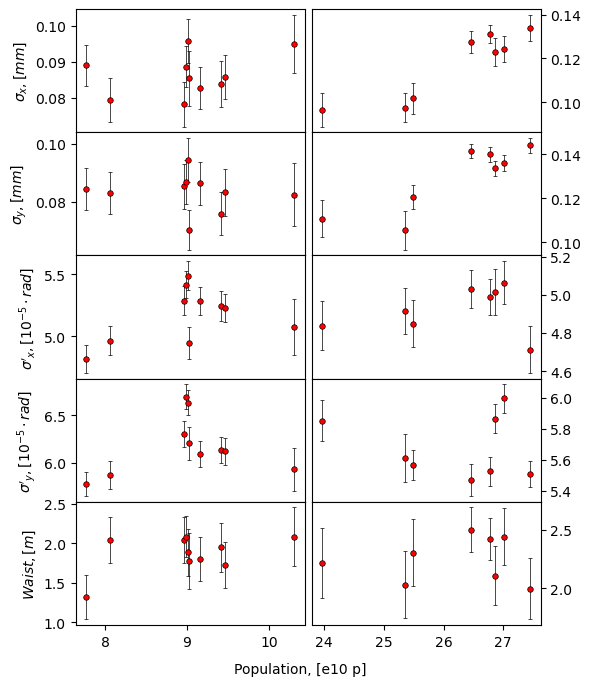

PyObject Text(0.5, 0.05, 'Population, [e10 p]')

In [31]:
fig, ax= plt.subplots(5,2, figsize=(6,8), sharex="col")
fig.subplots_adjust(hspace=0.00, wspace=0.03)



ax[1,1].errorbar(charges[msklc], mean_vals_1[msklc], yerr=std_vals_1[msklc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[1,2].errorbar(charges[mskhc], mean_vals_1[mskhc], yerr=std_vals_1[mskhc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[2,1].errorbar(charges[msklc], mean_vals_2[msklc], yerr=std_vals_2[msklc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[2,2].errorbar(charges[mskhc], mean_vals_2[mskhc], yerr=std_vals_2[mskhc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[3,1].errorbar(charges[msklc], mean_vals_3[msklc], yerr=std_vals_3[msklc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[3,2].errorbar(charges[mskhc], mean_vals_3[mskhc], yerr=std_vals_3[mskhc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[4,1].errorbar(charges[msklc], mean_vals_4[msklc], yerr=std_vals_4[msklc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[4,2].errorbar(charges[mskhc], mean_vals_4[mskhc], yerr=std_vals_4[mskhc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[5,1].errorbar(charges[msklc], mean_vals_5[msklc], yerr=std_vals_5[msklc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)

ax[5,2].errorbar(charges[mskhc], mean_vals_5[mskhc], yerr=std_vals_5[mskhc], 
        color="k", 
        fmt="o", markersize = 4,
        mfc="red",
        markeredgecolor = "k", markeredgewidth=0.5, 
        capsize=1.5, ecolor="k", elinewidth=0.5)


ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")

ax[3,2].yaxis.tick_right()
ax[3,2].yaxis.set_ticks_position("right")

ax[4,2].yaxis.tick_right()
ax[4,2].yaxis.set_ticks_position("right")

ax[5,2].yaxis.tick_right()
ax[5,2].yaxis.set_ticks_position("right")

ax[1,1].set_ylabel(L"\sigma_x, [mm]")
ax[2,1].set_ylabel(L"\sigma_y, [mm]")
ax[3,1].set_ylabel(L"\sigma'_x, [10^{-5} \cdot rad]")
ax[4,1].set_ylabel(L"\sigma'_y, [10^{-5} \cdot rad]")
ax[5,1].set_ylabel(L"Waist, [m]")

fig.text(0.5, 0.05, "Population, [e10 p]", ha="center")

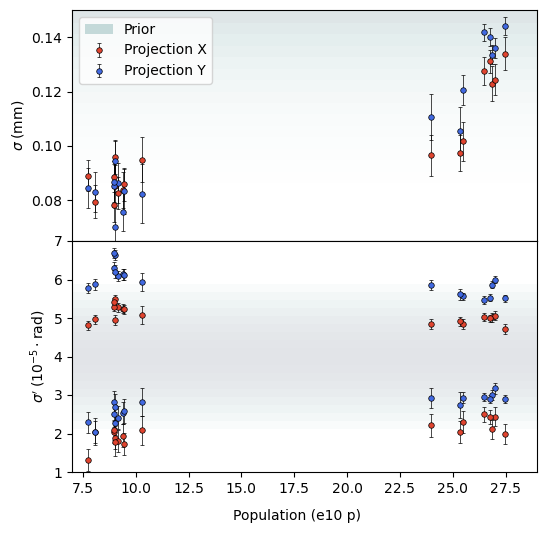

PyObject Text(0.5, 0.03, 'Population (e10 p)')

In [32]:
fig, ax= plt.subplots(2,1, figsize=(6,6), sharex="col")
fig.subplots_adjust(hspace=0.00, wspace=0.03)

ax[1].errorbar(charges, mean_vals_1, yerr=std_vals_1, 
    color="k", 
    fmt="o", markersize = 4,
    mfc=plt.cm.OrRd(0.7),
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5, label="Projection X"
)

ax[1].errorbar(charges, mean_vals_2, yerr=std_vals_2, 
    color="k", 
    fmt="o", markersize = 4,
    mfc="royalblue",
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5, label="Projection Y"
)

ax[2].errorbar(charges, mean_vals_3, yerr=std_vals_3, 
    color="k", 
    fmt="o", markersize = 4,
    mfc=plt.cm.OrRd(0.7),
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5
)

ax[2].errorbar(charges, mean_vals_4, yerr=std_vals_4, 
    color="k", 
    fmt="o", markersize = 4,
    mfc="royalblue",
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5
)

ax[2].errorbar(charges, mean_vals_5, yerr=std_vals_5, 
    color="k", 
    fmt="o", markersize = 4,
    mfc=plt.cm.OrRd(0.7),
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5
)

ax[2].errorbar(charges, mean_vals_6, yerr=std_vals_6, 
    color="k", 
    fmt="o", markersize = 4,
    mfc="royalblue",
    markeredgecolor = "k", markeredgewidth=0.5, 
    capsize=1.5, ecolor="k", elinewidth=0.5
)

xmin, xmax, nint = 7.0,29.0, 20
ymin, ymax = 2.0, 6.0
in_cent = range(ymin, stop=ymax, length=nint)
stpdelt = in_cent[2] - in_cent[1]
cols = pdf.(truncated(Normal(4.0, 2.0), 2.0, 6.0), in_cent); cols = cols .- minimum(cols) ; cols = cols ./ (2*maximum(cols))

for ind in eachindex(in_cent)
    r1 = matplotlib.patches.Rectangle([xmin, in_cent[ind] - stpdelt/2], xmax-xmin, stpdelt, fill=true, 
        linewidth=0, 
        color=plt.cm.bone_r(cols[ind]), alpha=0.2)

    ax[2].add_patch(r1)
end

ymin, ymax = 0.08, 0.16
in_cent = range(ymin, stop=ymax, length=nint)
stpdelt = in_cent[2] - in_cent[1]
cols = pdf.(truncated(Normal(0.2, 0.04), 0.08, 0.25), in_cent); cols = cols .- minimum(cols) ; cols = cols ./ (2*maximum(cols))

for ind in eachindex(in_cent)
    r1 = matplotlib.patches.Rectangle([xmin, in_cent[ind] - stpdelt/2], xmax-xmin, stpdelt, fill=true, 
        linewidth=0, 
        color=plt.cm.bone_r(cols[ind]), alpha=0.3)

    ax[1].add_patch(r1)
end

proxy = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.bone_r(0.17), label="Prior")
ax[1].add_patch(proxy)


ax[1,1].set_ylabel(L"\sigma \; \mathrm{(mm)}")
ax[2,1].set_ylabel(L"\sigma' \; \mathrm{(10^{-5} \cdot rad)}")

ax[2].set_xlim(7.0,29.0)
ax[2].set_ylim(1.0,7)
ax[1].set_ylim(0.065,0.15)

ax[1].legend(loc="upper left")

fig.text(0.5, 0.03, "Population (e10 p)", ha="center")
